In [869]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [1008]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [1632]:
array_shape = (4,4)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [1626]:
def get_baseline_key(i1, i2, shape=array_shape):
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [1634]:
def get_baselines(tele_num=telescope_number):
    redundant_baselines = {}
    for i in range(telescope_number):
        for j in range(telescope_number):
            if i==j:
                continue
            ordered_diff = (min(i,j), max(i,j))
            key = get_baseline_key(i,j)
            if key in redundant_baselines.keys():
                if ordered_diff in redundant_baselines[key]:
                    continue
                else:
                    redundant_baselines[key].append(ordered_diff)
            else:
                redundant_baselines[key] = [ordered_diff]            
    return redundant_baselines

In [1639]:
redundant_baselines = get_baselines()
baseline_indx = np.array(list(redundant_baselines.keys()))

In [1642]:
[0,-1] in baseline_indx

True

In [1630]:
# For square of N telescopes, should be 2N-2*sqrt(N) + 1
# Fix to a corner and there are N-1 options for unique baselines. 
# Flip over to other side (over x or y axis) and get another N-1 options
# Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
# Final +1 is from 0 baseline

baselines = basic_baselines.keys()
N_bases = len(baselines)

In [1631]:
N_bases

24

In [1605]:
rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)

In [1606]:
npcb = np.vectorize(pow)

In [1609]:
gain_amp = np.random.normal(1, .5, telescope_number)
if np.min(gain_amp) < 0:
    print("try again")
gain_phase = rand_phases(telescope_number)
tgain = gain_amp*np.exp(1j*gain_phase)

In [1610]:
sky_phase = {pkey:rand_phases(1) for pkey in baselines}
correl_sky = {pkey:np.random.normal(3, .1)*np.exp(1j*sky_phase[pkey]) for pkey in baselines}

In [1611]:
observation_baselines = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
for i in range(telescope_number):
    for k in range(telescope_number):
        key = get_baseline_key(i, k)
        sig = tgain[i]*np.conj(tgain[k])*correl_sky[key][0]
        noise = np.random.normal(.05,.01) + 1j*np.random.normal(.05,.01)
        observation_baselines[i,k] = sig+noise

In [1612]:
snr = np.abs(correl_sky[(0,0)])/np.abs(noise)
print("SNR is %f" % snr[0])

SNR is 46.680647


In [1613]:
# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
v0 = {pkey:np.mean(np.abs(observation_baselines))*np.exp(1j*rand_phases(1)) for pkey in baselines}

In [1614]:
iter_max = 400
delta = .4
eps = 1e-5

In [1615]:
garr = g0
varr = v0.copy()
y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
ratio = np.zeros(iter_max)

In [1616]:
for n in tqdm(range(iter_max)):
    oldx = np.concatenate((garr, np.array(list(varr.values())).flatten()))
    for i in range(telescope_number):
        for k in range(telescope_number):
            key = get_baseline_key(i, k)
            sig = garr[i]*np.conjugate(garr[k])*varr[key][0]
            y_ij[i,k] = sig
#             w_ij[i,k] = (sig**2)/(observation_baselines[i,i]*observation_baselines[k,k])
            w_ij[i,k] = 16
    gprime = garr*npcb(((w_ij*observation_baselines)/y_ij).sum(axis=1)/(w_ij.sum(axis=1)), 1/3)
    garr = (1 - delta)*garr + delta*gprime
    vprime = {}
    for i in baselines:
        numer = np.sum([((w_ij[indx]*observation_baselines[indx])/y_ij[indx]) for indx in basic_baselines[i]])
        denom = np.sum([w_ij[indx] for indx in basic_baselines[i]])
        vprime[i] = varr[i]*npcb(numer/denom, 1/3)
        varr[i] = (1-delta)*varr[i] + delta*vprime[i]
    vv = np.array(list(varr.values()))
#     vscale = np.mean(np.abs(observation_baselines))/np.mean(np.abs(vv))
    gscale = 1/np.mean(np.abs(garr))
    vscale = (1/gscale)**2
    garr = garr*gscale
    for i in baselines:
        varr[i] = varr[i]*vscale
    newx = np.concatenate((garr, np.array(list(varr.values())).flatten()))
    delx = newx - oldx
    step_r = np.linalg.norm(delx)/np.linalg.norm(oldx)
    ratio[n] = step_r
    if step_r < eps:
        break

<ipython-input-1617-cfdae5a033ed>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(ratio))


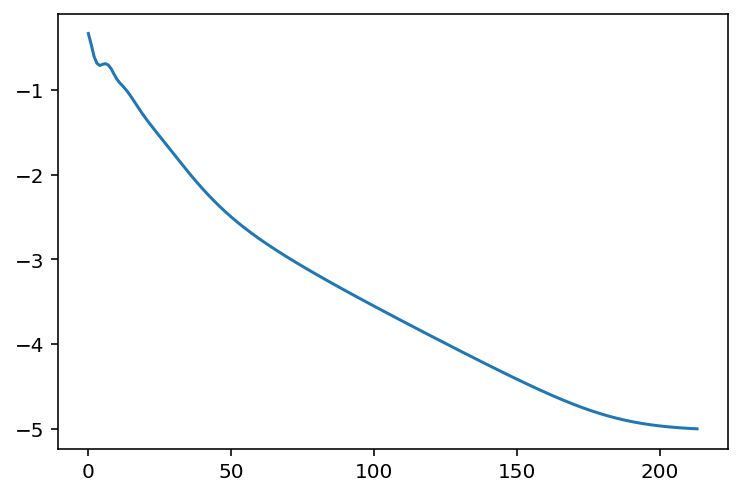

In [1617]:
plt.plot(np.log10(ratio))

In [1618]:
vv = np.array(list(varr.values()))
cc = np.array(list(correl_sky.values()))

In [1619]:
np.abs(tgain - garr)/np.abs(tgain)

array([0.24861059, 2.04872682, 0.22969472, 2.05263618, 0.22016537,
       2.04758863, 0.21915755, 2.04758694, 0.22953023, 2.04430293,
       0.23342263, 2.0461454 , 0.22877971, 2.03109273, 0.23041435,
       2.04178788])

In [1623]:
(np.abs(cc - vv)/np.abs(cc)).flatten()

array([0.02902581, 1.89194931, 0.13131418, 1.90276057, 0.12656029,
       1.89540354, 0.14603365, 1.84430934, 0.07891279, 1.89943462,
       0.12095975, 1.86122507, 0.11064756, 1.89215855, 0.09680755,
       1.89789054, 1.89619779, 1.90817615, 1.90634711, 0.13260245,
       0.11038484, 0.08853688, 1.92205837, 1.8861912 , 1.87764111])

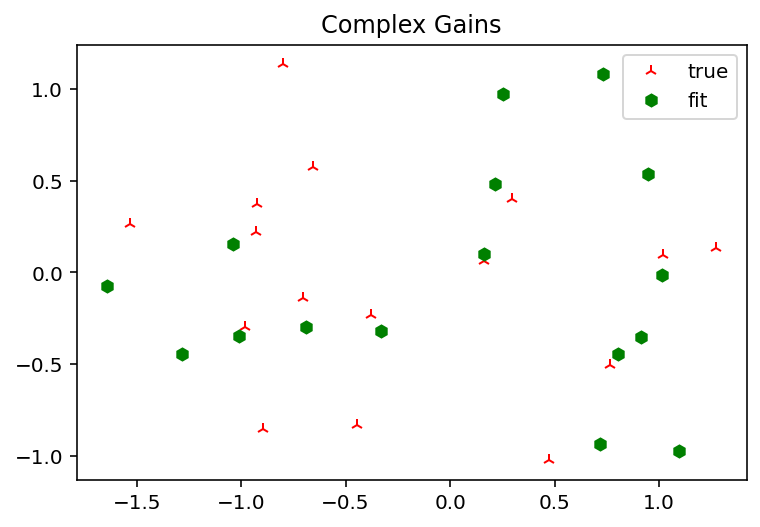

In [1621]:
plt.title('Complex Gains')
plt.plot(tgain.real, tgain.imag, 'r2', label='true')
plt.plot(garr.real, garr.imag, 'gh', label='fit')
plt.legend();

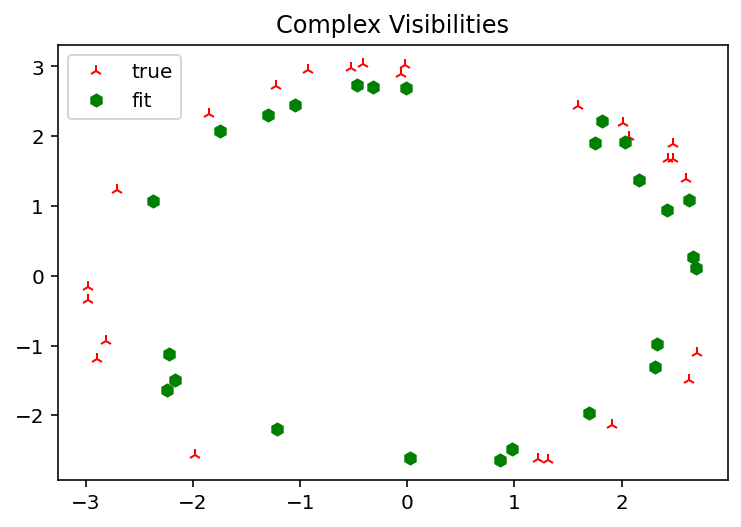

In [1622]:
plt.title("Complex Visibilities")
plt.plot(cc.real, cc.imag, 'r2', label='true')
plt.plot(vv.real, vv.imag, 'gh', label='fit')
plt.legend();

In [1253]:
((observation_baselines)/y_ij).sum(axis=1)

array([16.01062069+0.08143414j, 16.01058496+0.08143309j,
       16.01055504+0.08143574j, 16.01052349+0.08143622j,
       16.0105928 +0.081435j  , 16.01058078+0.08143509j,
       16.01057045+0.08143536j, 16.01056131+0.08143588j,
       16.01055914+0.08143573j, 16.01057044+0.08143593j,
       16.01057997+0.08143596j, 16.01059251+0.0814354j ,
       16.01052367+0.08143671j, 16.01055485+0.08143483j,
       16.01058723+0.08143571j, 16.01061794+0.08143521j])

In [1377]:
npcb(vv, 1/3);